In [2]:
from scripts import *
from acclimate.dataset import AcclimateOutput

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
# path to the forcing data
forcingpath = "/home/quante/Documents/projects/acclimate-system-response/tmp/river_flood_test.nc"
forcing_output = AcclimateOutput(forcingpath,groups_to_load=["firms"])

In [5]:
# path to the random forcing data to compare
random_path = "/home/quante/Documents/projects/acclimate-system-response/tmp/output_5_year_random.nc"
random_output = AcclimateOutput(random_path,groups_to_load=["firms"])

In [8]:
#function to calculate baseline relative data:

def baseline_relative(data,baseline_timeindex=0):
    return data/data.sel(time=data.time[baseline_timeindex])

# def preprocessing
def preprocessing_loss_data_by_regions(output):
    #aggregate production value by region:
    firm_data = output.sel(agent_type="firm")
    regional_firm_data = firm_data.groupby('agent_region').sum().chunk("auto")
    #select variables of interest
    variables = ["firms_total_loss_value","firms_total_loss_quantity","firms_direct_loss_value","firms_direct_loss_quantity","firms_forcing"]
    loss_forcing_data = regional_firm_data[variables]
    loss_forcing_data["firms_indirect_loss_value"]=loss_forcing_data["firms_total_loss_value"]-loss_forcing_data["firms_direct_loss_value"]
    loss_forcing_data["firms_indirect_loss_quantity"]=loss_forcing_data["firms_total_loss_quantity"]-loss_forcing_data["firms_direct_loss_quantity"]
    loss_forcing_data["firms_forcing"]= baseline_relative(loss_forcing_data["firms_forcing"]) #TODO: weighting by sector
    return loss_forcing_data.to_dataframe()
    

In [82]:
# save as csv for faster reusing
forcing_data = preprocessing_loss_data_by_regions(forcing_output)
forcing_data.to_csv("/home/quante/Documents/projects/acclimate-system-response/tmp/forcing_loss_data.csv")

/home/quante/miniconda3/envs/acclimate-system-response/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 266 times more chunks
  return self.array[key]


In [10]:
# save as csv for faster reusing
random_data = preprocessing_loss_data_by_regions(random_output)
random_data.to_csv("/home/quante/Documents/projects/acclimate-system-response/tmp/random_5_years_loss_data.csv")

In [104]:
forcing_data = pd.read_csv("/home/quante/Documents/projects/acclimate-system-response/tmp/forcing_loss_data.csv",index_col=[0,1])

In [105]:
random_data = pd.read_csv("/home/quante/Documents/projects/acclimate-system-response/tmp/random_5_years_loss_data.csv",index_col=[0,1])

In [106]:
random_data

firms_total_loss_value  firms_total_loss_quantity  \
agent_region time                                                            
ABW          2000-01-01                0.000000                      0.000   
             2000-01-02              435.704000                    435.704   
             2000-01-03              566.568458                    566.543   
             2000-01-04             1761.988658                   1770.695   
             2000-01-05             1976.445428                   1979.590   
...                                         ...                        ...   
ZMB          2004-12-27            17513.665735                  17251.862   
             2004-12-28            12721.760633                  12592.116   
             2004-12-29             4295.209913                   4311.562   
             2004-12-30            19395.924424                  19238.191   
             2004-12-31            15133.509595                  14923.652   

                         firms_direct_loss_value  firms_direct_loss_quantity  \
agent_region time                                                              
ABW          2000-01-01                 0.000000                       0.000   
             2000-01-02               534.507000                     534.507   
             2000-01-03               141.715478                     141.709   
             2000-01-04              1819.821899                    1828.699   
             2000-01-05              1252.724866                    1254.129   
...                                          ...                         ...   
ZMB          2004-12-27             15716.485081                   15513.965   
             2004-12-28              5767.837006                    5717.039   
             2004-12-29              4319.346186                    4328.200   
             2004-12-30             20437.906396                   20262.554   
             2004-12-31                 0.000000                       0.000   

                         firms_forcing  firms_indirect_loss_value  \
agent_region time                                                   
ABW          2000-01-01       1.000000                   0.000000   
             2000-01-02       0.948678                 -98.803000   
             2000-01-03       0.986394                 424.852980   
             2000-01-04       0.824413                 -57.833242   
             2000-01-05       0.879582                 723.720561   
...                                ...                        ...   
ZMB          2004-12-27       0.851366                1797.180654   
             2004-12-28       0.945227                6953.923628   
             2004-12-29       0.958533                 -24.136273   
             2004-12-30       0.805871               -1041.981972   
             2004-12-31       1.000000               15133.509595   

                         firms_indirect_loss_quantity  
agent_region time                                      
ABW          2000-01-01                         0.000  
             2000-01-02                       -98.803  
             2000-01-03                       424.834  
             2000-01-04                       -58.004  
             2000-01-05                       725.461  
...                                               ...  
ZMB          2004-12-27                      1737.897  
             2004-12-28                      6875.077  
             2004-12-29                       -16.638  
             2004-12-30                     -1024.363  
             2004-12-31                     14923.652  

[485982 rows x 7 columns]

In [15]:
def dataframe_columns_by_regions(data,regions,variable):
    dataframe = pd.DataFrame(columns=regions)
    appended_regions = []
    for i_region in regions:
        appended_regions.append(i_region+"_"+variable)
    dataframe = pd.DataFrame(columns=appended_regions)
    for i_region in regions:
        query = "agent_region == '"+i_region+"'"
        region_vector = data.query(query)[variable]
        region_vector.index = region_vector.index.droplevel(level="agent_region")
        dataframe[i_region+"_"+variable]=region_vector
    return dataframe

def timeslice_data(dataframe,timeslice="'2001-01-01' <=time <= '2004-12-31'"):
    return dataframe.query(timeslice)

def variable_by_regions(dataframe,variable):
    regions = dataframe.index.levels[0] ##TODO: make robust
    return  dataframe_columns_by_regions(dataframe,regions,variable)                      

In [96]:
### use pca to get macro perspective, covariance structure to get micro perspective

from sklearn import cluster
from sklearn import decomposition
from sklearn import  preprocessing

from numpy.random import RandomState

In [107]:
n_components = 10
variable = "firms_indirect_loss_quantity"
# normalize data for better interpretation, TBD: more sophisticated weighting etc.
random_timeslice = variable_by_regions(timeslice_data(random_data),variable)
forcing_timeslice = variable_by_regions(timeslice_data(forcing_data),variable)


In [74]:
def plot_two_components(estimator):

    pc_names = []
    index=1
    for i_components in estimator.components_:
        pc_names.append("PC"+str(index))
        index+=1

    pca_df = pd.DataFrame(columns=pc_names)
    index=0
    for i_components in estimator.components_:
        pca_df[pc_names[index]]=estimator.components_[index]
        index+=1

    fig, ax = plt.subplots()
    pca_df.plot.scatter(x="PC1", y="PC2", ax=ax)
    return pca_df

In [111]:
def screen_pca (data,variance_explained=5):
    standardized_data = preprocessing.scale(data,axis=0) #TODO: more spohisticated?!
    rng = RandomState(0)
    pca = decomposition.PCA(n_components=variance_explained, random_state=rng)
    pca.fit(standardized_data)
    fig = plt.plot(pca.explained_variance_ratio_,label="explained variance ratio by pc",marker="o",ls="")
    title = plt.gca().set_title("explained variance ratio")
    plot_two_components(pca)

### compare pca results

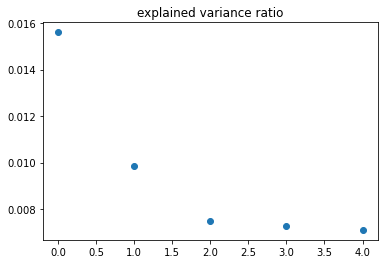

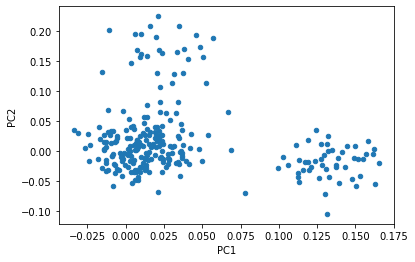

In [112]:
screen_pca(random_timeslice,variance_explained=5)

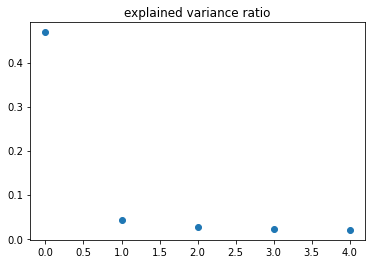

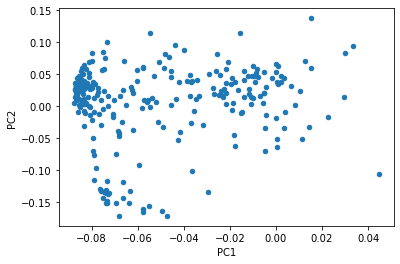

In [113]:
screen_pca(forcing_timeslice,variance_explained=5)

### compare correlation matrices

In [114]:
def continental_labels(data):
    continent_columns = []
    from acclimate import definitions
    continents = ["AFR","ASI","EUR","NAM","LAM","OCE"]
    continent_columns = []
    continental_data = data.copy()
    for i_country in list(data.columns):
        iso_code = i_country[0:3]
        continent=""
        for i_continent in continents:
            if iso_code in (definitions.WORLD_REGIONS[i_continent]):
                continent = i_continent
            else:
                if "US." in iso_code:
                    continent = "NAM"   
                if "CN." in iso_code:
                    continent = "ASI" 
        continent_columns.append(str(continent+ "." + iso_code))
    continental_data.columns = continent_columns
    #sort columns alphabetically
    continental_data = continental_data.sort_index(axis=1)
    return continental_data

In [120]:
random_by_continents = continental_labels(random_timeslice)

forcing_by_continents = continental_labels(forcing_timeslice)

In [138]:
def correlation_matrix(data,scenario=""):
    X = preprocessing.StandardScaler().fit_transform(data)

    feature_names = data.columns
    ax = plt.axes()
    #set main diagonal to NaN
    correlation = np.corrcoef(X.T)
    np.fill_diagonal(correlation,np.NaN)
    im = ax.imshow(correlation, cmap="RdBu_r")


    plt.colorbar(im).ax.set_ylabel("$r$", rotation=0)
    ax.set_title(scenario+"indirect losses correlation matrix")
    plt.tight_layout()

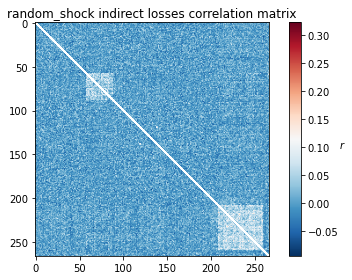

In [140]:
correlation_matrix(random_by_continents,scenario="random_shock ")

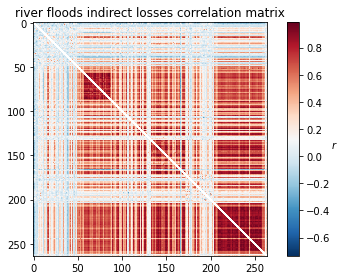

In [141]:
correlation_matrix(forcing_by_continents,scenario="river floods ")